# Data exploration

In [3]:
import pandas as pd
import numpy as np
import unidecode
import warnings
warnings.filterwarnings('ignore')

In [5]:
df1 = pd.read_excel("https://raw.githubusercontent.com/carlosgeovany/Sentiment-Analysis/main/data/asmt_assessment_instance_question.xls", usecols="C,M,N,U")

In [6]:
df2 = pd.read_excel("https://raw.githubusercontent.com/carlosgeovany/Sentiment-Analysis/main/data/asmt_assessment_instance_question_comments.xlsx", usecols="C,H,I,P")

In [7]:
df = pd.concat([df1,df2])

In [8]:
df = df[df['String value'].notnull()]

In [9]:
df.groupby('Language')["Created"].count().reset_index().sort_values(ascending=False, by="Created")

,Language,Created
4,English,5600
19,Spanish,5074
0,Brazilian Portuguese,2639
5,French,1268
9,Italian,811
3,Dutch,765
6,German,496
13,Polish,484
16,Russian,366
14,Portuguese,309


### Select languages

In [10]:
df = df.query('Language in ["English"]')

### Format date column

In [11]:
df['Created'] =  pd.to_datetime(df['Created'], format='%Y-%m-%d %H:%M:%S').apply(lambda x: x.date())

### Remove accents and other unicode characters

In [12]:
df['String value'] = df['String value'].apply(lambda x: unidecode.unidecode(x))

### Remove puntuations, digits and lowercase the comments

In [13]:
# Remove all the special characters
df['String value'] = df['String value'].str.replace(r'\W', ' ')
# remove all single characters
df['String value'] = df['String value'].str.replace(r'\s+[a-zA-Z]\s+', ' ')
# Remove single characters from the start
df['String value'] = df['String value'].str.replace(r'\^[a-zA-Z]\s+', ' ')
# Substituting multiple spaces with single space
df['String value'] = df['String value'].str.replace(r'^\s+', ' ')
# Lowercase the strings
df['String value'] = df['String value'].str.lower()

df = df[df['String value'].notnull()]
df = df[df['String value']!=' ']
df.head(5)

,Number.1,Language,Created,String value
0,INC3019918,English,2020-08-23,david solved the issue right over the phone ca...
6,INC3019462,English,2020-08-22,excellent service thank you kevin
49,INC3017886,English,2020-08-21,thanks for resolving helen
67,INC3017608,English,2020-08-21,super friendly and most helpful even called m...
79,INC3017422,English,2020-08-21,it went really quick as now know that you can...


### Remove specific words from each dataset

In [14]:
remove = ["request","ticket","issue"]
df['String value'] = df['String value'].str.replace('|'.join(remove), '')

# Topic Modeling

### Remove Stop Words

In [19]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\w10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop = stopwords.words('english')
df['String value'] = df['String value'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

### Lemmatization

In [23]:
# Lemmatization
import spacy

In [25]:
def lemmatization(texts):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        temp = " ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc])
        # Compresses double spaces
        texts_out.append(" ".join(temp.split()))
    return texts_out
  
# Initialize spacy 'en' model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Turn each comment in a list of words
data = df['String value'].str.strip(',').str.split(' ')
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data)

### Word Cloud

In [27]:
# Import the wordcloud library
from wordcloud import WordCloud

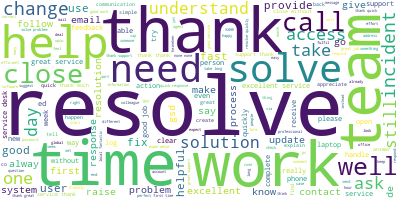

In [29]:
# Join the different processed titles together.
long_string = ','.join(list(data_lemmatized))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Defining the best # of topics

In [30]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [31]:
vectorizer = CountVectorizer(analyzer='word', min_df=15)
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [32]:
# GridSearch best LDA model - extended search

# Define Search Param
search_params = {'n_components': [3, 4, 5, 6, 7, 8, 9, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online',batch_size=64, max_iter=50)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

# Model Performance - extended

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -38130.82398104568
Model Perplexity:  289.62893338819936


In [33]:
import matplotlib.pyplot as plt

In [34]:
n_components = [3, 4, 5, 6, 7, 8, 9, 10]
log_likelyhoods_5 = model.cv_results_["mean_test_score"][0:8]
log_likelyhoods_7 = model.cv_results_["mean_test_score"][8:16]
log_likelyhoods_9 = model.cv_results_["mean_test_score"][16:]

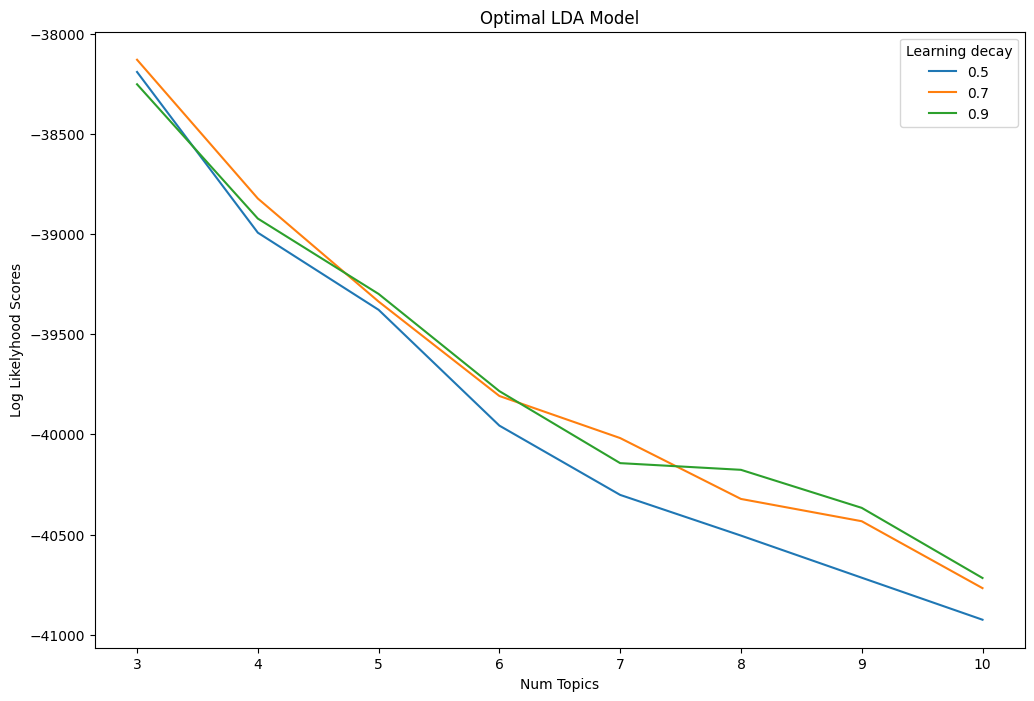

In [65]:
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')
plt.title("Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### Generating pyLDAvis graph

In [37]:
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda

C:\Users\w10\AppData\Local\Programs\Python\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [38]:
%matplotlib inline

lda = LatentDirichletAllocation(n_components=3)
lda.fit(data_vectorized)
LDAvis_prepared = sklearn_lda.prepare(lda, data_vectorized, vectorizer)
pyLDAvis.enable_notebook()
pyLDAvis.display(LDAvis_prepared)

### Dataframe with the top 15 words by topic generated

In [40]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = [i for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,good,resolve,service,excellent,solve,problem,incident,none,call,work,keep,de,phone,helpful,time
1,time,take,get,close,work,change,would,need,provide,email,ask,first,user,long,solution
2,thank,great,support,quick,service,resolve,response,fast,team,help,quickly,job,helpful,much,access


# Sentiment Analysis

### We train our model based on the tweets about six US airlines, pre classified as neutral, negative and positive

Implementation based on [Sentiment Analysis with scikit-learn](https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/) and [Sentiment Analysis with python](https://github.com/KatamAkash/Sentiment-Analysis-with-Python-NLTK-Text-Classification/blob/master/Bag%20of%20words%20of%20IMDB%20reviews-Copy1.ipynb)

### Importing the data set

In [46]:
import seaborn as sns
import re
import nltk
%matplotlib inline

In [48]:
data_source_url = "https://raw.githubusercontent.com/carlosgeovany/Sentiment-Analysis/main/data/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

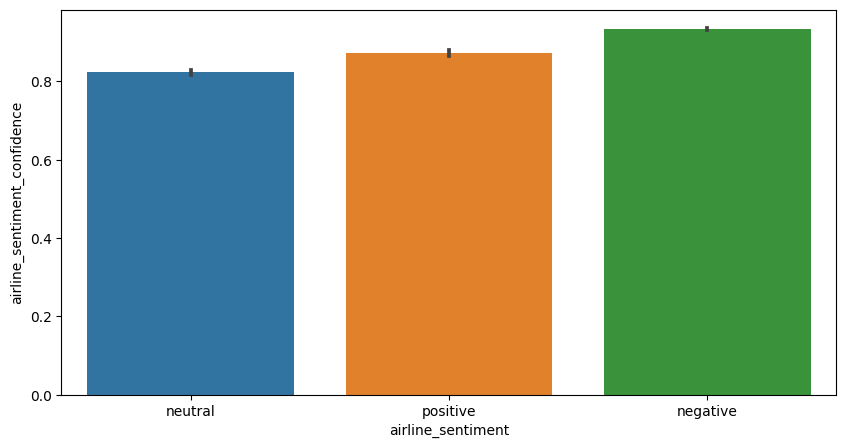

In [49]:
plt.figure(figsize=(10,5))
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)
plt.show()

In [50]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

## Data Cleaning

In [51]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

### Training the model

In [52]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)
predictions = text_classifier.predict(X_test)

### Evaluating the Model accuracy

In [53]:
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995


### We have achieved an accuracy of 75.99

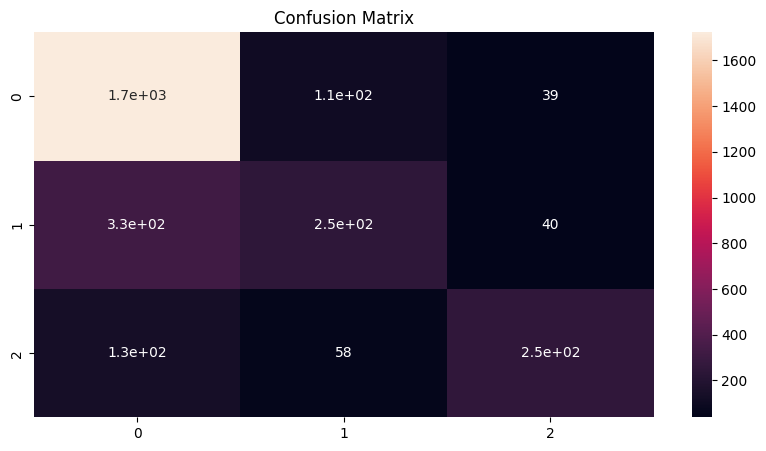

In [54]:
conf_mat = confusion_matrix(y_test,predictions)
plt.figure(figsize=(10,5))
sns.heatmap(conf_mat, annot = True)
plt.title('Confusion Matrix')
plt.show()

### Apling the model to our dataset

In [56]:
df["Class"] = df["String value"].apply(lambda x: text_classifier.predict(vectorizer.transform([x])))
df['Class'] = [','.join(map(str, l)) for l in df['Class']]

In [57]:
df.Class.value_counts()

negative    3760
positive    1580
neutral       58
Name: Class, dtype: int64

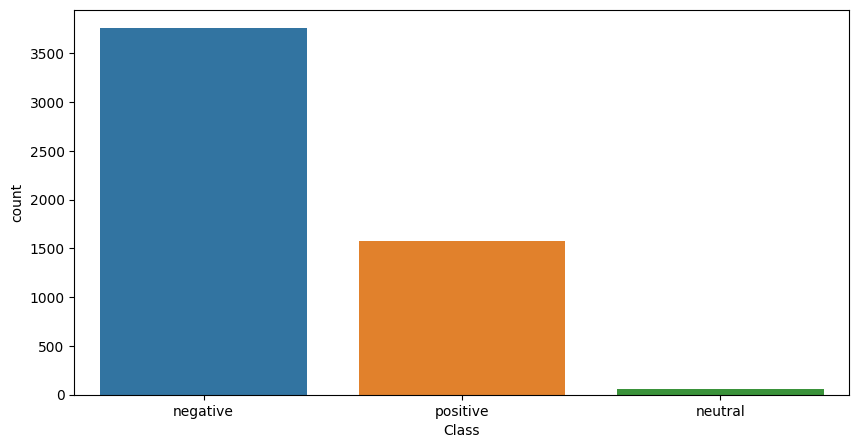

In [58]:
plt.figure(figsize=(10,5))
sns.countplot(x='Class', data=df)
plt.show()

### Time series by language and sentiment

In [59]:
df['Created'] = pd.to_datetime(df['Created'])
df['Created'] = df['Created'].dt.strftime('%Y-%m')

In [60]:
df['count'] = 1
df = df.groupby(['Created','Class'])['count'].sum().reset_index(name='count')

In [61]:
df.sort_values(by="Created").head(10)

,Created,Class,count
0,2019-07,negative,100
1,2019-07,positive,28
2,2019-08,negative,197
3,2019-08,neutral,4
4,2019-08,positive,40
5,2019-09,negative,193
6,2019-09,neutral,2
7,2019-09,positive,55
9,2019-10,neutral,8
10,2019-10,positive,106


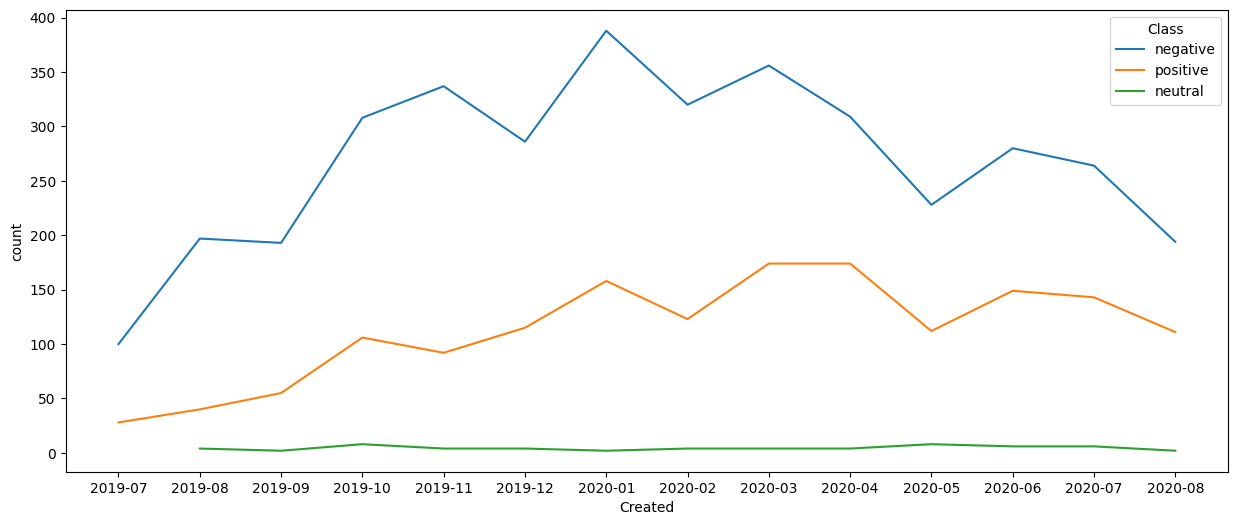

In [63]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x='Created', y='count', hue='Class')
plt.show()